In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
import math

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
df = pd.read_csv("./airbnb-price-prediction.csv")

In [4]:
pd.set_option('display.max_columns', None)
df = df.drop(['name', 'thumbnail_url', 'id', 'description', 'first_review', 'host_since', 'last_review', 'neighbourhood', 'host_response_rate'], axis=1)
df.head()

,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
0,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,t,t,f,40.696524,-73.991617,2,100.0,11201,1.0,1.0
1,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,t,f,t,40.766115,-73.989040,6,93.0,10019,3.0,3.0
2,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,t,t,t,40.808110,-73.943756,10,92.0,10027,1.0,3.0
3,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,t,t,f,37.772004,-122.431619,0,NaN,94117.0,2.0,2.0
4,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,t,t,t,38.925627,-77.034596,4,40.0,20009,0.0,1.0


# Assumptions
Looking at the data I've got few assumptions:

1 - Is the log_price competetive in the places(zipcodes) where there are lots of AirBnbs (We'll take apartments in LA)

2 - Does reviews matter ? (We'll take the AirBnbs who have outstanding reviews(number and percentage))

3 - If the AirBnb is more close to the center of the city, is it costly ? (We have the city name. We can google the center coordinates of the city. We'll calculate the distance using the formula given on https://kite.com/python/answers/how-to-find-the-distance-between-two-lat-long-coordinates-in-python)

# Let's check the Dataset !!

In [5]:
df.describe()

,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,74111.000000,74111.000000,73911.000000,74111.000000,74111.000000,74111.000000,57389.000000,74020.000000,73980.000000
mean,4.782069,3.155146,1.235263,38.445958,-92.397525,20.900568,94.067365,1.265793,1.710868
std,0.717394,2.153589,0.582044,3.080167,21.705322,37.828641,7.836556,0.852143,1.254142
min,0.000000,1.000000,0.000000,33.338905,-122.511500,0.000000,20.000000,0.000000,0.000000
25%,4.317488,2.000000,1.000000,34.127908,-118.342374,1.000000,92.000000,1.000000,1.000000
50%,4.709530,2.000000,1.000000,40.662138,-76.996965,6.000000,96.000000,1.000000,1.000000
75%,5.220356,4.000000,1.000000,40.746096,-73.954660,23.000000,100.000000,1.000000,2.000000
max,7.600402,16.000000,8.000000,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000


This shows that there are maximum of 74111 records and some of the features have missing values (but these are just numerical features). 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 20 columns):
log_price                 74111 non-null float64
property_type             74111 non-null object
room_type                 74111 non-null object
amenities                 74111 non-null object
accommodates              74111 non-null int64
bathrooms                 73911 non-null float64
bed_type                  74111 non-null object
cancellation_policy       74111 non-null object
cleaning_fee              74111 non-null bool
city                      74111 non-null object
host_has_profile_pic      73923 non-null object
host_identity_verified    73923 non-null object
instant_bookable          74111 non-null object
latitude                  74111 non-null float64
longitude                 74111 non-null float64
number_of_reviews         74111 non-null int64
review_scores_rating      57389 non-null float64
zipcode                   73145 non-null object
bedrooms                  

In [7]:
df.shape

(74111, 20)

# Cleaning the data before analysis

In [8]:
df.isnull().sum()

log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   200
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
host_has_profile_pic        188
host_identity_verified      188
instant_bookable              0
latitude                      0
longitude                     0
number_of_reviews             0
review_scores_rating      16722
zipcode                     966
bedrooms                     91
beds                        131
dtype: int64

In [9]:
fill_0 = lambda col: col.fillna(0)
num_df = df.select_dtypes(include=['float', 'int'])
num_df_lst = num_df.columns[num_df.isnull().sum() > 0]
df_clean_num = df[num_df_lst].apply(fill_0, axis=0)
df = pd.concat([df.drop(num_df_lst, axis=1), df_clean_num], axis=1)

In [10]:
df.isnull().sum()

log_price                   0
property_type               0
room_type                   0
amenities                   0
accommodates                0
bed_type                    0
cancellation_policy         0
cleaning_fee                0
city                        0
host_has_profile_pic      188
host_identity_verified    188
instant_bookable            0
latitude                    0
longitude                   0
number_of_reviews           0
zipcode                   966
bathrooms                   0
review_scores_rating        0
bedrooms                    0
beds                        0
dtype: int64

In [11]:
df['zipcode'] = df['zipcode'].str.strip()
df['zipcode'].replace('', np.nan, inplace=True)

In [12]:
cat_df = df.select_dtypes(include=['object'])
cat_df_lst = cat_df.columns[cat_df.isnull().sum() > 0]
df.dropna(subset=cat_df_lst, axis=0, inplace=True)

In [13]:
df.isnull().sum()

log_price                 0
property_type             0
room_type                 0
amenities                 0
accommodates              0
bed_type                  0
cancellation_policy       0
cleaning_fee              0
city                      0
host_has_profile_pic      0
host_identity_verified    0
instant_bookable          0
latitude                  0
longitude                 0
number_of_reviews         0
zipcode                   0
bathrooms                 0
review_scores_rating      0
bedrooms                  0
beds                      0
dtype: int64

In [14]:
df.shape

(72957, 20)

In [15]:
df = df[~df['zipcode'].str.contains('-', regex=False)]
df = df[~df['zipcode'].str.contains('\r', regex=False)]
df = df[~df['zipcode'].str.contains('Near', regex=False)]
df = df[~df['zipcode'].str.contains('1m', regex=False)]

In [16]:
df['zipcode'] = df['zipcode'].astype(float)

In [17]:
df.dtypes

log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                int64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
host_has_profile_pic       object
host_identity_verified     object
instant_bookable           object
latitude                  float64
longitude                 float64
number_of_reviews           int64
zipcode                   float64
bathrooms                 float64
review_scores_rating      float64
bedrooms                  float64
beds                      float64
dtype: object

In [18]:
df['amenities'].head()

0    {"Wireless Internet","Air conditioning",Kitche...
1    {"Wireless Internet","Air conditioning",Kitche...
2    {TV,"Cable TV","Wireless Internet","Air condit...
3    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
4    {TV,Internet,"Wireless Internet","Air conditio...
Name: amenities, dtype: object

# Cleaning the Amenities column

In [19]:
def seperate_am(x):
    if '{' in x:
        x = x.replace('{', '')
    if '}' in x:
        x = x.replace('}', '')
    if '"' in x:
        x = x.replace('"', '')
    lst = x.split(',')
    
    return lst

In [20]:
df_sep_am = df.copy()
df_sep_am['amenities'] = df_sep_am['amenities'].apply(seperate_am)
df = pd.concat([df.drop(['amenities'], axis=1), pd.get_dummies(df_sep_am['amenities'].apply(pd.Series), prefix='', prefix_sep='amenities_', drop_first=True).sum(level=0, axis=1)], axis=1)

In [21]:
df.shape

(72938, 148)

In [22]:
df.head()

,log_price,property_type,room_type,accommodates,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,instant_bookable,latitude,longitude,number_of_reviews,zipcode,bathrooms,review_scores_rating,bedrooms,beds,amenities_Air conditioning,amenities_Breakfast,amenities_Buzzer/wireless intercom,amenities_Cable TV,amenities_Carbon monoxide detector,amenities_Doorman,amenities_Elevator,amenities_Elevator in building,amenities_Essentials,amenities_Family/kid friendly,amenities_Fire extinguisher,amenities_First aid kit,amenities_Free parking on premises,amenities_Gym,amenities_Heating,amenities_Host greets you,amenities_Internet,amenities_Kitchen,amenities_Laptop friendly workspace,amenities_Lock on bedroom door,amenities_Pets allowed,amenities_Pets live on this property,amenities_Pool,amenities_Self Check-In,amenities_Shampoo,amenities_Single level home,amenities_Smoke detector,amenities_Smoking allowed,amenities_Stair gates,amenities_Stove,amenities_Suitable for events,amenities_TV,amenities_Washer,amenities_Wheelchair accessible,amenities_Wide entryway,amenities_Wireless Internet,amenities_translation missing: en.hosting_amenity_49,amenities_translation missing: en.hosting_amenity_50,amenities_Cat(s),amenities_Children’s books and toys,amenities_Dog(s),amenities_Doorman Entry,amenities_Dryer,amenities_Hair dryer,amenities_Hangers,amenities_Hot tub,amenities_Indoor fireplace,amenities_Lockbox,amenities_Other pet(s),amenities_Private living room,amenities_Coffee maker,amenities_Free parking on street,amenities_Hot water,amenities_Iron,amenities_Microwave,amenities_Other,amenities_Paid parking off premises,amenities_Private entrance,amenities_Washer / Dryer,amenities_Waterfront,amenities_Window guards,amenities_Bed linens,amenities_Keypad,amenities_Refrigerator,amenities_Safety card,amenities_Smart lock,amenities_Smartlock,amenities_Babysitter recommendations,amenities_Bathtub,amenities_Children’s dinnerware,amenities_Dishes and silverware,amenities_Dishwasher,amenities_Game console,amenities_Garden or backyard,amenities_Luggage dropoff allowed,amenities_BBQ grill,amenities_Cooking basics,amenities_Extra pillows and blankets,amenities_Oven,amenities_Pack ’n Play/travel crib,amenities_Room-darkening shades,amenities_Hot water kettle,amenities_Long term stays allowed,amenities_Baby monitor,amenities_Changing table,amenities_Ethernet connection,amenities_Patio or balcony,amenities_Private bathroom,amenities_Step-free access,amenities_Well-lit path to entrance,amenities_Baby bath,amenities_Cleaning before checkout,amenities_Flat,amenities_Outlet covers,amenities_Pocket wifi,amenities_24-hour check-in,amenities_High chair,amenities_Wide doorway,amenities_Wide hallway clearance,amenities_Firm mattress,amenities_Table corner guards,amenities_Crib,amenities_Fireplace guards,amenities_Accessible-height bed,amenities_Accessible-height toilet,amenities_Handheld shower head,amenities_Wide clearance to bed,amenities_Lake access,amenities_Beach essentials,amenities_Fixed grab bars for shower & toilet,amenities_Path to entrance lit at night,amenities_EV charger,amenities_Ski in/Ski out,amenities_Air purifier,amenities_Beachfront,amenities_Ground floor access,amenities_Roll-in shower with chair,amenities_Wide clearance to shower & toilet,amenities_Body soap,amenities_Firm matress,amenities_Hand soap,amenities_Bath towel,amenities_Bathtub with shower chair,amenities_Hand or paper towel,amenities_Toilet paper,amenities_Disabled parking spot,amenities_Flat smooth pathway to front door,amenities_Grab-rails for shower and toilet,amenities_Wide clearance to shower and toilet
0,5.010635,Apartment,Entire home/apt,3,Real Bed,strict,True,NYC,t,t,f,40.696524,-73.991617,2,11201.0,1.0,100.0,1.0,1.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [23]:
len(df.columns[df.columns.str.contains('amenities')])

129

# Data Analysis

We're going to selectively sample out data by taking in consideration that the Airbnbs in the dataset would be a perfect choice for a couple.

In [32]:
df_choose = df[(df['accommodates']==2)&(df['bedrooms']==1)&(df['beds']==1)&(df['bathrooms']==1)
               &(df['property_type']=='Apartment')&(df['room_type']=='Entire home/apt')]

In [33]:
df_choose.shape

(5453, 148)

In [34]:
df_citymean = df_choose[['city', 'log_price']].groupby(['city'], as_index=False).mean().sort_values('log_price', ascending=False)
df_citymean

,city,log_price
5,SF,5.185174
0,Boston,5.118842
4,NYC,4.981495
2,DC,4.922020
3,LA,4.727164
1,Chicago,4.639280


The mean log_price in SF is higher than others

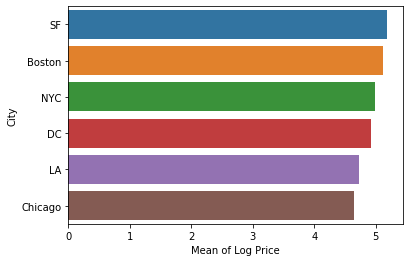

In [35]:
ax = sns.barplot(data=df_citymean, x='log_price', y='city', ci=None)
ax.set(xlabel='Mean of Log Price', ylabel='City')
plt.show()

Text(0, 0.5, '')

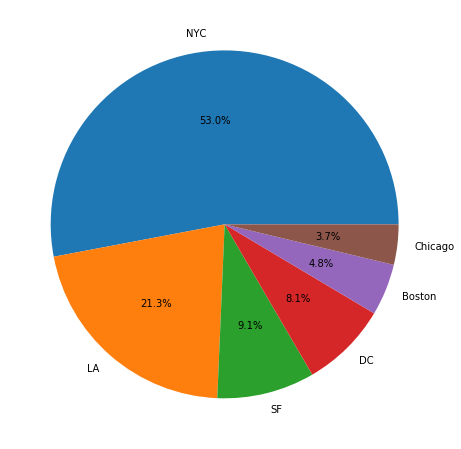

In [36]:
df_citycount = df_choose[['city', 'log_price']].groupby(['city'], as_index=False).count().sort_values('log_price', ascending=False)
df_citycount.rename(columns = {'log_price':'count'}, inplace = True)
ax = df_choose['city'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
ax.set_ylabel('')

And we have more data on NYC than on SF.

In [37]:
max(df_choose['log_price'])

7.6004023345004

In [38]:
min(df_choose['log_price'])

2.302585092994046

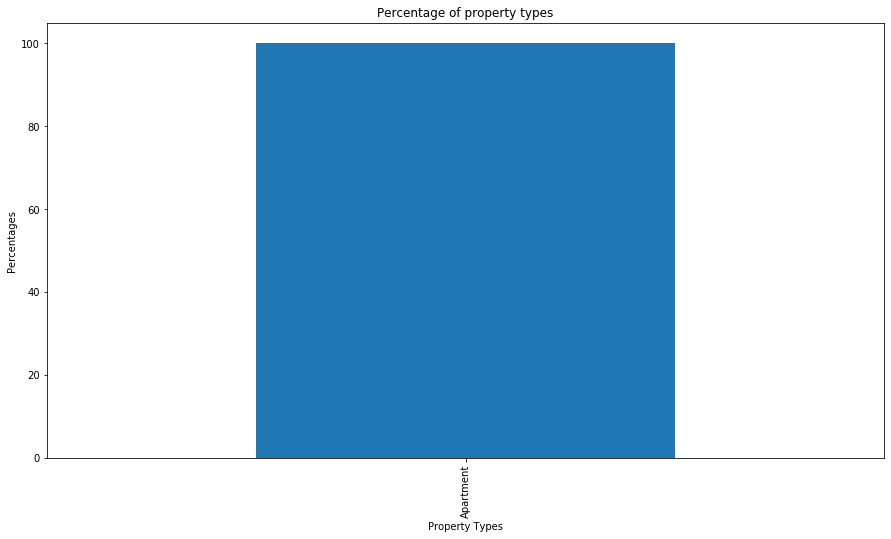

In [39]:
plt.figure(figsize=(15,8))
property_types = df_choose['property_type'].value_counts()
((property_types/df_choose.shape[0])*100).plot(kind="bar")
plt.title("Percentage of property types")
plt.xlabel('Property Types')
plt.ylabel('Percentages')
plt.show()

67% of AirBnbs are Apartments

In [40]:
df_count_each = df_choose.groupby(['property_type', 'room_type'])['room_type'].count().unstack('room_type')
df_count_each["sum"] = df_count_each.sum(axis=1)
df_count_each = df_count_each.sort_values('sum', ascending=False)
df_count_each.head()

room_type,Entire home/apt,sum
property_type,,
Apartment,5453,5453


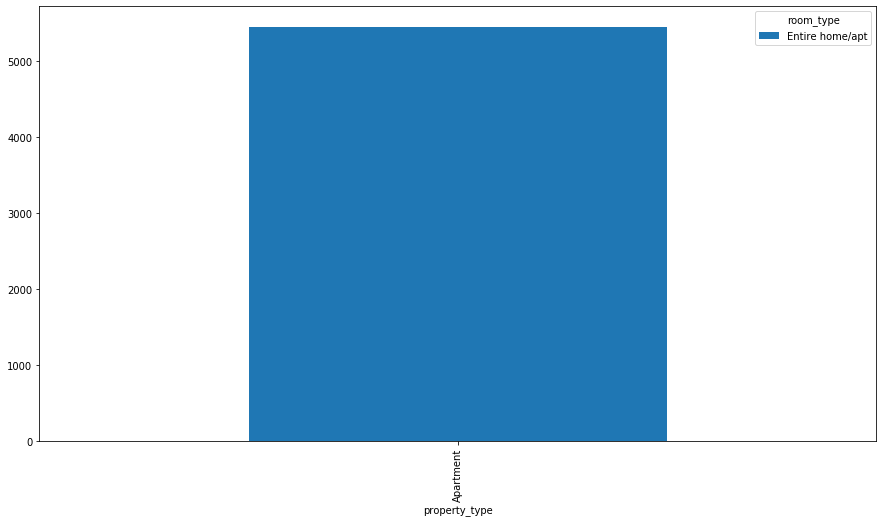

In [41]:
df_count_each.drop(['sum'],axis=1).plot(kind='bar', stacked=True, figsize=(15,8))

From the above visualization we can clearly see the room_types in the starting four. Just to check out the whole data we'll stretch the count of each preperty_type to 100% and check out the room_types in all the property_types.

room_type,Entire home/apt
property_type,
Apartment,100.0


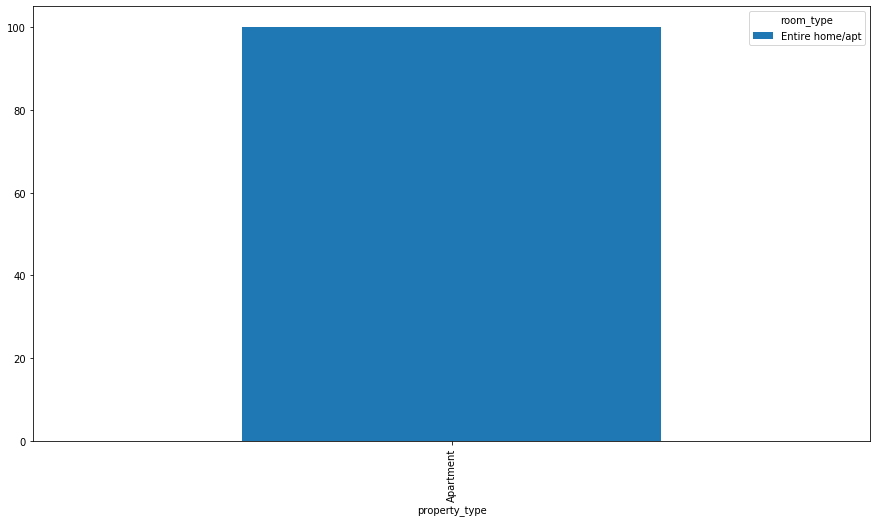

In [42]:
df_test = df_choose.groupby(['property_type', 'room_type'])['room_type'].count().unstack('room_type')
df_test["sum"] = df_test.sum(axis=1)
df_test = df_test.sort_values('sum', ascending=False)
df_test = df_test.drop(['sum'],axis=1)
df_test = df_test.apply(lambda x: (x / df_test.sum(axis=1))*100)
df_test.plot(kind='bar', stacked=True, figsize=(15,8))
df_test.head()

We can say that all the AirBnb Hostels have more of Shared rooms than private rooms. The visualization is clear.

In [43]:
df[['instant_bookable', 'log_price']].groupby(['instant_bookable'], as_index=False).mean()

,instant_bookable,log_price
0,f,4.800913
1,t,4.728277


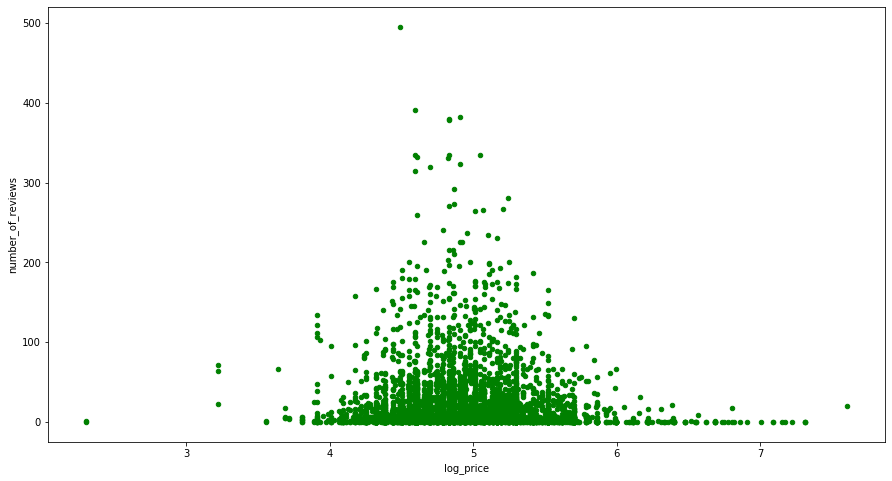

In [44]:
df_choose[['number_of_reviews', 'log_price']].plot.scatter(y='number_of_reviews', x='log_price', legend=False, c='Green', figsize=(15,8))

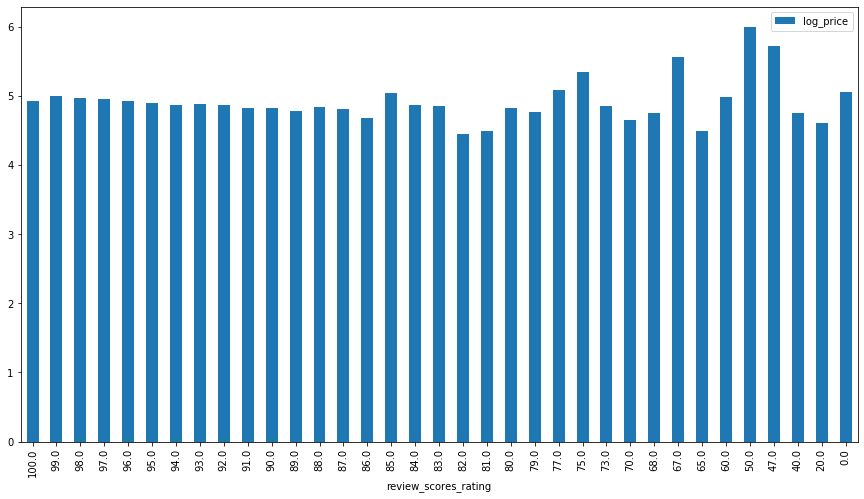

In [45]:
df_choose[['review_scores_rating', 'log_price']].groupby(['review_scores_rating'], as_index=False).mean().sort_values(by='review_scores_rating',ascending=False).plot.bar(x='review_scores_rating', y='log_price', figsize=(15,8))

Coming back to prove our assumption

In [47]:
df_choose['property_type'] = df_choose['property_type'].str.strip()

df_a_la = df_choose

more_airbnb = df_a_la.groupby(['zipcode']).zipcode.value_counts().nlargest(1)
more_airbnb_lst = list(more_airbnb.index.droplevel(level=0))

# less_airbnb = df_a_la.groupby(['zipcode']).zipcode.value_counts().nsmallest(3)
# less_airbnb_lst = list(less_airbnb.index.droplevel(level=0))

# df_more_airbnb = df_a_la[(df_a_la['zipcode'].isin(more_airbnb_lst))]
# df_less_airbnb = df_a_la[(df_a_la['zipcode'].isin(less_airbnb_lst))]

# df_compare_zipcodes = pd.concat([df_more_airbnb, df_less_airbnb], axis=0)

C:\Users\bune1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [48]:
df_more_airbnb.shape

(181, 148)

In [49]:
df_more_airbnb.head()

,log_price,property_type,room_type,accommodates,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,instant_bookable,latitude,longitude,number_of_reviews,zipcode,bathrooms,review_scores_rating,bedrooms,beds,amenities_Air conditioning,amenities_Breakfast,amenities_Buzzer/wireless intercom,amenities_Cable TV,amenities_Carbon monoxide detector,amenities_Doorman,amenities_Elevator,amenities_Elevator in building,amenities_Essentials,amenities_Family/kid friendly,amenities_Fire extinguisher,amenities_First aid kit,amenities_Free parking on premises,amenities_Gym,amenities_Heating,amenities_Host greets you,amenities_Internet,amenities_Kitchen,amenities_Laptop friendly workspace,amenities_Lock on bedroom door,amenities_Pets allowed,amenities_Pets live on this property,amenities_Pool,amenities_Self Check-In,amenities_Shampoo,amenities_Single level home,amenities_Smoke detector,amenities_Smoking allowed,amenities_Stair gates,amenities_Stove,amenities_Suitable for events,amenities_TV,amenities_Washer,amenities_Wheelchair accessible,amenities_Wide entryway,amenities_Wireless Internet,amenities_translation missing: en.hosting_amenity_49,amenities_translation missing: en.hosting_amenity_50,amenities_Cat(s),amenities_Children’s books and toys,amenities_Dog(s),amenities_Doorman Entry,amenities_Dryer,amenities_Hair dryer,amenities_Hangers,amenities_Hot tub,amenities_Indoor fireplace,amenities_Lockbox,amenities_Other pet(s),amenities_Private living room,amenities_Coffee maker,amenities_Free parking on street,amenities_Hot water,amenities_Iron,amenities_Microwave,amenities_Other,amenities_Paid parking off premises,amenities_Private entrance,amenities_Washer / Dryer,amenities_Waterfront,amenities_Window guards,amenities_Bed linens,amenities_Keypad,amenities_Refrigerator,amenities_Safety card,amenities_Smart lock,amenities_Smartlock,amenities_Babysitter recommendations,amenities_Bathtub,amenities_Children’s dinnerware,amenities_Dishes and silverware,amenities_Dishwasher,amenities_Game console,amenities_Garden or backyard,amenities_Luggage dropoff allowed,amenities_BBQ grill,amenities_Cooking basics,amenities_Extra pillows and blankets,amenities_Oven,amenities_Pack ’n Play/travel crib,amenities_Room-darkening shades,amenities_Hot water kettle,amenities_Long term stays allowed,amenities_Baby monitor,amenities_Changing table,amenities_Ethernet connection,amenities_Patio or balcony,amenities_Private bathroom,amenities_Step-free access,amenities_Well-lit path to entrance,amenities_Baby bath,amenities_Cleaning before checkout,amenities_Flat,amenities_Outlet covers,amenities_Pocket wifi,amenities_24-hour check-in,amenities_High chair,amenities_Wide doorway,amenities_Wide hallway clearance,amenities_Firm mattress,amenities_Table corner guards,amenities_Crib,amenities_Fireplace guards,amenities_Accessible-height bed,amenities_Accessible-height toilet,amenities_Handheld shower head,amenities_Wide clearance to bed,amenities_Lake access,amenities_Beach essentials,amenities_Fixed grab bars for shower & toilet,amenities_Path to entrance lit at night,amenities_EV charger,amenities_Ski in/Ski out,amenities_Air purifier,amenities_Beachfront,amenities_Ground floor access,amenities_Roll-in shower with chair,amenities_Wide clearance to shower & toilet,amenities_Body soap,amenities_Firm matress,amenities_Hand soap,amenities_Bath towel,amenities_Bathtub with shower chair,amenities_Hand or paper towel,amenities_Toilet paper,amenities_Disabled parking spot,amenities_Flat smooth pathway to front door,amenities_Grab-rails for shower and toilet,amenities_Wide clearance to shower and toilet
209,4.787492,Apartment,Entire home/apt,2,Real Bed,strict,True,NYC,t,t,f,40.707740,-73.951122,9,11211.0,1.0,93.0,1.0,1.0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [50]:
df_more_airbnb[ 'log_price'].mean()

4.99362801977328

In [51]:
max(df_more_airbnb['log_price'])

5.703782474656202

In [52]:
min(df_more_airbnb['log_price'])

4.07753744390572

In [53]:
df_more_airbnb[df_more_airbnb.columns[df_more_airbnb.columns.str.contains('amenities')]].head()

,amenities_Air conditioning,amenities_Breakfast,amenities_Buzzer/wireless intercom,amenities_Cable TV,amenities_Carbon monoxide detector,amenities_Doorman,amenities_Elevator,amenities_Elevator in building,amenities_Essentials,amenities_Family/kid friendly,amenities_Fire extinguisher,amenities_First aid kit,amenities_Free parking on premises,amenities_Gym,amenities_Heating,amenities_Host greets you,amenities_Internet,amenities_Kitchen,amenities_Laptop friendly workspace,amenities_Lock on bedroom door,amenities_Pets allowed,amenities_Pets live on this property,amenities_Pool,amenities_Self Check-In,amenities_Shampoo,amenities_Single level home,amenities_Smoke detector,amenities_Smoking allowed,amenities_Stair gates,amenities_Stove,amenities_Suitable for events,amenities_TV,amenities_Washer,amenities_Wheelchair accessible,amenities_Wide entryway,amenities_Wireless Internet,amenities_translation missing: en.hosting_amenity_49,amenities_translation missing: en.hosting_amenity_50,amenities_Cat(s),amenities_Children’s books and toys,amenities_Dog(s),amenities_Doorman Entry,amenities_Dryer,amenities_Hair dryer,amenities_Hangers,amenities_Hot tub,amenities_Indoor fireplace,amenities_Lockbox,amenities_Other pet(s),amenities_Private living room,amenities_Coffee maker,amenities_Free parking on street,amenities_Hot water,amenities_Iron,amenities_Microwave,amenities_Other,amenities_Paid parking off premises,amenities_Private entrance,amenities_Washer / Dryer,amenities_Waterfront,amenities_Window guards,amenities_Bed linens,amenities_Keypad,amenities_Refrigerator,amenities_Safety card,amenities_Smart lock,amenities_Smartlock,amenities_Babysitter recommendations,amenities_Bathtub,amenities_Children’s dinnerware,amenities_Dishes and silverware,amenities_Dishwasher,amenities_Game console,amenities_Garden or backyard,amenities_Luggage dropoff allowed,amenities_BBQ grill,amenities_Cooking basics,amenities_Extra pillows and blankets,amenities_Oven,amenities_Pack ’n Play/travel crib,amenities_Room-darkening shades,amenities_Hot water kettle,amenities_Long term stays allowed,amenities_Baby monitor,amenities_Changing table,amenities_Ethernet connection,amenities_Patio or balcony,amenities_Private bathroom,amenities_Step-free access,amenities_Well-lit path to entrance,amenities_Baby bath,amenities_Cleaning before checkout,amenities_Flat,amenities_Outlet covers,amenities_Pocket wifi,amenities_24-hour check-in,amenities_High chair,amenities_Wide doorway,amenities_Wide hallway clearance,amenities_Firm mattress,amenities_Table corner guards,amenities_Crib,amenities_Fireplace guards,amenities_Accessible-height bed,amenities_Accessible-height toilet,amenities_Handheld shower head,amenities_Wide clearance to bed,amenities_Lake access,amenities_Beach essentials,amenities_Fixed grab bars for shower & toilet,amenities_Path to entrance lit at night,amenities_EV charger,amenities_Ski in/Ski out,amenities_Air purifier,amenities_Beachfront,amenities_Ground floor access,amenities_Roll-in shower with chair,amenities_Wide clearance to shower & toilet,amenities_Body soap,amenities_Firm matress,amenities_Hand soap,amenities_Bath towel,amenities_Bathtub with shower chair,amenities_Hand or paper towel,amenities_Toilet paper,amenities_Disabled parking spot,amenities_Flat smooth pathway to front door,amenities_Grab-rails for shower and toilet,amenities_Wide clearance to shower and toilet
209,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
390,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
636,1,0,1,0,1,0,0,0,1,0,1,1,0,0,1,0,1,1,1,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0

In [54]:
all_amenities = df_more_airbnb.columns[df_more_airbnb.columns.str.contains('amenities')]
nec_amenities = ['amenities_Air conditioning', 'amenities_Cable TV', 'amenities_Carbon monoxide detector',
                 'amenities_Essentials', 'amenities_Free parking on premises', 'amenities_Internet', 'amenities_Kitchen',
                 'amenities_Pets allowed', 'amenities_Pool', 'amenities_TV', 'amenities_Wireless Internet', 'amenities_Hot water',
                 'amenities_Refrigerator']
other_amenities = list(set(all_amenities) - set(nec_amenities))

df_more_airbnb['amenities_other'] = df_more_airbnb[other_amenities].sum(axis=1)
df_more_airbnb = df_more_airbnb.drop(other_amenities, axis=1)

C:\Users\bune1\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [55]:
df_more_airbnb['amenities_other'] = (df_more_airbnb['amenities_other'] > 0).astype(int)

In [56]:
df_more_airbnb.head()

,log_price,property_type,room_type,accommodates,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,instant_bookable,latitude,longitude,number_of_reviews,zipcode,bathrooms,review_scores_rating,bedrooms,beds,amenities_Air conditioning,amenities_Cable TV,amenities_Carbon monoxide detector,amenities_Essentials,amenities_Free parking on premises,amenities_Internet,amenities_Kitchen,amenities_Pets allowed,amenities_Pool,amenities_TV,amenities_Wireless Internet,amenities_Hot water,amenities_Refrigerator,amenities_other
209,4.787492,Apartment,Entire home/apt,2,Real Bed,strict,True,NYC,t,t,f,40.707740,-73.951122,9,11211.0,1.0,93.0,1.0,1.0,0,0,1,1,1,1,1,0,0,0,1,0,0,1
390,5.393628,Apartment,Entire home/apt,2,Real Bed,flexible,True,NYC,t,f,f,40.716328,-73.956216,2,11211.0,1.0,100.0,1.0,1.0,1,1,0,1,0,1,1,0,0,1,1,0,0,1
636,4.779123,Apartment,Entire home/apt,2,Real Bed,moderate,True,NYC,t,t,f,40.711276,-73.953998,6,11211.0,1.0,97.0,1.0,1.0,1,0,1,1,0,1,1,1,0,1,1,0,0,1
785,4.553877,Apartment,Entire home/apt,2,Real Bed,flexible,True,NYC,t,t,f,40.718327,-73.957478,52,11211.0,1.0,91.0,1.0,1.0,1,0,0,1,0,1,1,1,0,1,1,0,0,1
1786,5.273000,Apartment,Entire home/apt,2,Real Bed,strict,True,NYC,t,t,f,40.720663,-73.953079,19,11211.0,1.0,96.0,1.0,1.0,1,1,1,1,0,1,1,0,0,1,1,0,0,1


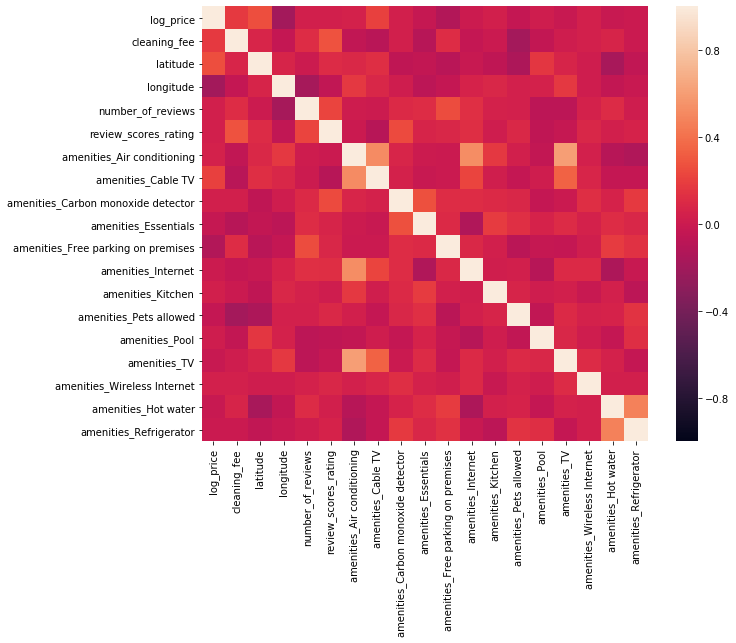

In [57]:
plt.figure(figsize=(10,8))
sns.heatmap(df_more_airbnb.drop(['accommodates', 'zipcode', 'bathrooms', 'bedrooms', 'beds', 'amenities_other'],axis=1).corr(), vmin=-1);

Text(0, 0.5, 'log_price')

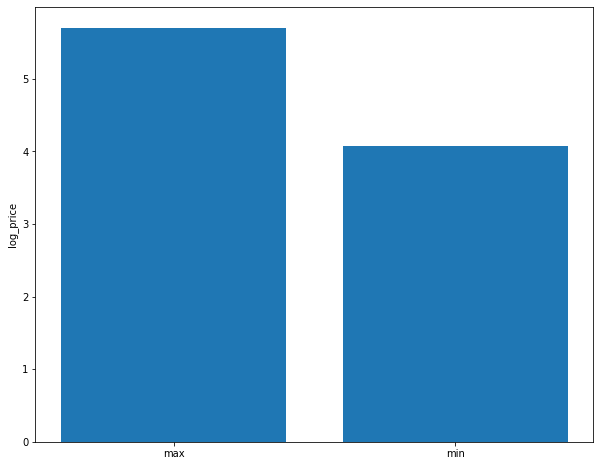

In [58]:
plt.figure(figsize=(10,8))
plt.bar(['max', 'min'], [max(df_more_airbnb['log_price']), min(df_more_airbnb['log_price'])], align='center')
plt.ylabel('log_price')

# Conclusion - The log_prices are not competetive in the places based on zipcodes where there are a lot of Airbnbs.

The analysis above also answers my second question. No, the reviews doesn't matter. However the analysis was done on a little set of data, we'll still check this on larger dataset.

# Assumption 3

In [59]:
lst = ['NYC', 'SF', 'DC', 'LA']

In [60]:
df_sel_city = df_choose[(df_choose['city']=='NYC')|(df_choose['city']=='SF')|(df_choose['city']=='DC')|(df_choose['city']=='LA')]

In [61]:
R = 6373.0

centers = {
    'NYC':{
        'latitude': 40.71427,
        'longitute': -74.00597
    },
    'DC':{
        'latitude': 38.9072,
        'longitute': 77.0369
    },
    'LA':{
        'latitude': 34.0522,
        'longitute': 118.2437
    },
    'SF':{
        'latitude': 37.7749,
        'longitute': 122.4194
    }
}

def calculate_distance(city, x, y):    
    lat1 = math.radians(centers.get(city)['latitude'])
    lon1 = math.radians(centers.get(city)['longitute'])
    lat2 = math.radians(x)
    lon2 = math.radians(y)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

#     distance = np.sqrt((dlat)**2+(dlon)**2)

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    
    return round(distance/1000,4)

In [62]:
df_sel_city['center_dist_km'] = [calculate_distance(city, x, y) for city, x, y in zip(df_sel_city['city'], df_sel_city['latitude'], df_sel_city['longitude'])]

C:\Users\bune1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [63]:
df_sel_city.head()

,log_price,property_type,room_type,accommodates,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,instant_bookable,latitude,longitude,number_of_reviews,zipcode,bathrooms,review_scores_rating,bedrooms,beds,amenities_Air conditioning,amenities_Breakfast,amenities_Buzzer/wireless intercom,amenities_Cable TV,amenities_Carbon monoxide detector,amenities_Doorman,amenities_Elevator,amenities_Elevator in building,amenities_Essentials,amenities_Family/kid friendly,amenities_Fire extinguisher,amenities_First aid kit,amenities_Free parking on premises,amenities_Gym,amenities_Heating,amenities_Host greets you,amenities_Internet,amenities_Kitchen,amenities_Laptop friendly workspace,amenities_Lock on bedroom door,amenities_Pets allowed,amenities_Pets live on this property,amenities_Pool,amenities_Self Check-In,amenities_Shampoo,amenities_Single level home,amenities_Smoke detector,amenities_Smoking allowed,amenities_Stair gates,amenities_Stove,amenities_Suitable for events,amenities_TV,amenities_Washer,amenities_Wheelchair accessible,amenities_Wide entryway,amenities_Wireless Internet,amenities_translation missing: en.hosting_amenity_49,amenities_translation missing: en.hosting_amenity_50,amenities_Cat(s),amenities_Children’s books and toys,amenities_Dog(s),amenities_Doorman Entry,amenities_Dryer,amenities_Hair dryer,amenities_Hangers,amenities_Hot tub,amenities_Indoor fireplace,amenities_Lockbox,amenities_Other pet(s),amenities_Private living room,amenities_Coffee maker,amenities_Free parking on street,amenities_Hot water,amenities_Iron,amenities_Microwave,amenities_Other,amenities_Paid parking off premises,amenities_Private entrance,amenities_Washer / Dryer,amenities_Waterfront,amenities_Window guards,amenities_Bed linens,amenities_Keypad,amenities_Refrigerator,amenities_Safety card,amenities_Smart lock,amenities_Smartlock,amenities_Babysitter recommendations,amenities_Bathtub,amenities_Children’s dinnerware,amenities_Dishes and silverware,amenities_Dishwasher,amenities_Game console,amenities_Garden or backyard,amenities_Luggage dropoff allowed,amenities_BBQ grill,amenities_Cooking basics,amenities_Extra pillows and blankets,amenities_Oven,amenities_Pack ’n Play/travel crib,amenities_Room-darkening shades,amenities_Hot water kettle,amenities_Long term stays allowed,amenities_Baby monitor,amenities_Changing table,amenities_Ethernet connection,amenities_Patio or balcony,amenities_Private bathroom,amenities_Step-free access,amenities_Well-lit path to entrance,amenities_Baby bath,amenities_Cleaning before checkout,amenities_Flat,amenities_Outlet covers,amenities_Pocket wifi,amenities_24-hour check-in,amenities_High chair,amenities_Wide doorway,amenities_Wide hallway clearance,amenities_Firm mattress,amenities_Table corner guards,amenities_Crib,amenities_Fireplace guards,amenities_Accessible-height bed,amenities_Accessible-height toilet,amenities_Handheld shower head,amenities_Wide clearance to bed,amenities_Lake access,amenities_Beach essentials,amenities_Fixed grab bars for shower & toilet,amenities_Path to entrance lit at night,amenities_EV charger,amenities_Ski in/Ski out,amenities_Air purifier,amenities_Beachfront,amenities_Ground floor access,amenities_Roll-in shower with chair,amenities_Wide clearance to shower & toilet,amenities_Body soap,amenities_Firm matress,amenities_Hand soap,amenities_Bath towel,amenities_Bathtub with shower chair,amenities_Hand or paper towel,amenities_Toilet paper,amenities_Disabled parking spot,amenities_Flat smooth pathway to front door,amenities_Grab-rails for shower and toilet,amenities_Wide clearance to shower and toilet,center_dist_km
14,4.955827,Apartment,Entire home/apt,2,Real Bed,strict,True,LA,t,t,f,33.778526,-118.145926,2,90804.0,1.0,100.0,1.0,1.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

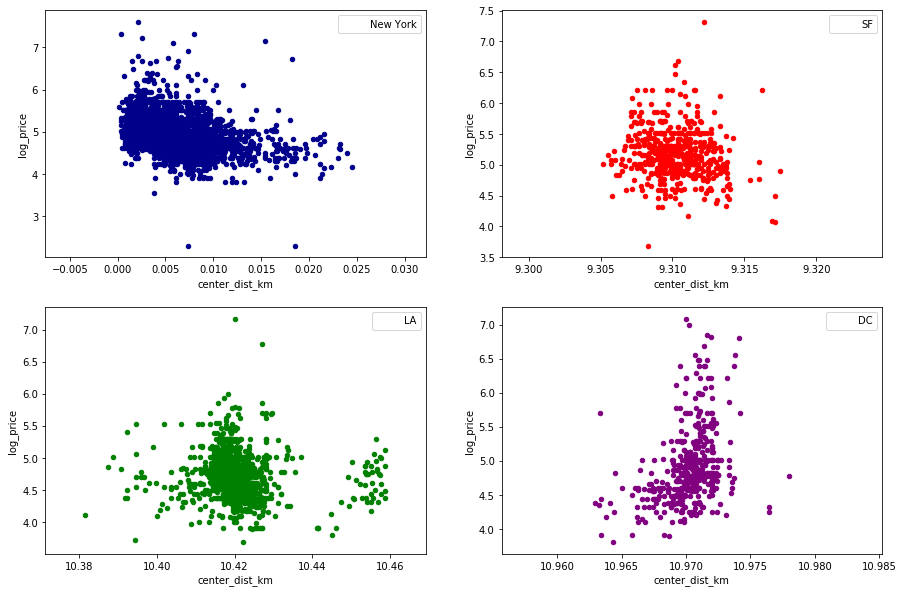

In [64]:
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
df_sel_city[df_sel_city['city']=='NYC'].plot.scatter(y='log_price', x='center_dist_km', ax=ax1, legend=True, c='DarkBlue')
pop_a = mpatches.Patch(color='None', label='New York')
plt.legend(handles=[pop_a])

ax2 = fig.add_subplot(222)
df_sel_city[df_sel_city['city']=='SF'].plot.scatter(y='log_price', x='center_dist_km', ax=ax2, legend=True, c='Red')
pop_a = mpatches.Patch(color='None', label='SF')
plt.legend(handles=[pop_a])

ax3 = fig.add_subplot(223)
df_sel_city[df_sel_city['city']=='LA'].plot.scatter(y='log_price', x='center_dist_km', ax=ax3, legend=True, c='Green')
pop_a = mpatches.Patch(color='None', label='LA')
plt.legend(handles=[pop_a])

ax4 = fig.add_subplot(224)
df_sel_city[df_sel_city['city']=='DC'].plot.scatter(y='log_price', x='center_dist_km', ax=ax4, legend=True, c='Purple')
pop_a = mpatches.Patch(color='None', label='DC')
plt.legend(handles=[pop_a])

In [65]:
df_sel_city[(df_sel_city.columns[~df_sel_city.columns.str.contains('amenities')])]

,log_price,property_type,room_type,accommodates,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,instant_bookable,latitude,longitude,number_of_reviews,zipcode,bathrooms,review_scores_rating,bedrooms,beds,center_dist_km
14,4.955827,Apartment,Entire home/apt,2,Real Bed,strict,True,LA,t,t,f,33.778526,-118.145926,2,90804.0,1.0,100.0,1.0,1.0,10.4564
44,5.783825,Apartment,Entire home/apt,2,Real Bed,flexible,False,LA,t,t,t,33.975708,-118.449596,1,90292.0,1.0,80.0,1.0,1.0,10.4212
45,5.521461,Apartment,Entire home/apt,2,Real Bed,flexible,False,NYC,t,f,f,40.768933,-73.953772,0,10021.0,1.0,0.0,1.0,1.0,0.0075
46,5.010635,Apartment,Entire home/apt,2,Real Bed,moderate,True,DC,t,t,f,38.901936,-77.052309,1,20037.0,1.0,0.0,1.0,1.0,10.9721
51,4.753590,Apartment,Entire home/apt,2,Real Bed,flexible,True,NYC,t,f,f,40.752150,-74.004255,0,10001.0,1.0,0.0,1.0,1.0,0.0042
53,4.828314,Apartment,Entire home/apt,2,Real Bed,flexible,True,LA,t,t,f,34.156491,-118.456518,0,91403.0,1.0,0.0,1.0,1.0,10.4063
56,4.682131,Apartment,Entire home/apt,2,Real Bed,strict,True,NYC,t,t,f,40.734115,-73.997873,31,10011.0,1.0,94.0,1.0,1.0,0.0023
57,4.948760,Apartment,Entire home/apt,2,Real Bed,strict,True,NYC,t,t,f,40.739612,-73.999762,2,10011.0,1.0,80.0,1.0,1.0,0.0029
71,5.010635,Apartment,Entire home/apt,2,Real Bed,moderate,False,NYC,t,f,f,40.759901,-73.962625,0,10022.0,1.0,0.0,1.0,1.0,0.0063
72,4.605170,Apartment,Entire home/apt,2,Real Bed,flexible,True,LA,t,f,f,34.167781,-118.282121,0,91201.0,1.0,0.0,1.0,1.0,10.4165


# Predictive Model

In [66]:
def get_other_dums(df, lst):
    for col in lst:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_')], axis=1)
        except:
            continue
    return df

In [67]:
get_other_dums_lst = ['room_type', 'bed_type', 'cleaning_fee', 'city', 'host_has_profile_pic', 'host_identity_verified',
                     'instant_bookable', 'cancellation_policy', 'property_type']
df_all_dums = get_other_dums(df, get_other_dums_lst)

In [68]:
df_all_dums.drop(df_all_dums[df_all_dums['zipcode']=='90036-2514'].index , inplace=True)
response_col = ['log_price']
X = df_all_dums.drop(response_col, axis=1)
y = df_all_dums[response_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ln_reg = LinearRegression()
ln_reg.fit(X_train, y_train) #Fit

#Predict using your model
y_test_preds = ln_reg.predict(X_test)
y_train_preds = ln_reg.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

C:\Users\bune1\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [69]:
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.615720789521721.  The rsquared on the test data was 0.6172255935090534.
